In [149]:
import pandas as pd
import numpy as np
import bamboolib

In [150]:
data = pd.read_csv('data/data_ready.csv')

# Get the Y labels
map_code = {'non-graine':0, 'graine':1}
data['label'] = data['sentiment'].map(map_code)

In [151]:
emb = {}
emb['tfidf'] = np.load('embeddings/tfidf.npy')
emb['bert'] = np.load('embeddings/bert.npy')
emb['features'] = np.load('embeddings/features.npy')
emb['profile_pictures'] = np.load('embeddings/full_profile_pictures.npy')

In [38]:
full_list = (emb['tfidf'], emb['profile_pictures'], emb['features'], emb['bert'])

X = np.concatenate(full_list, axis=1)

In [50]:
#visualization

In [115]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


data = pd.read_csv("data/data_ready.csv", index_col=[0])
emb = np.load("embeddings/tfidf.npy")

data['label'] = data['label'].astype('object')

pca = PCA(n_components = 2)
emb_pca = pca.fit_transform(emb)

df_emb = pd.DataFrame(emb_pca)
df_emb = pd.concat([df_emb, data], axis=1)

In [147]:
emb = np.load("embeddings/tfidf.npy", allow_pickle=True)
data = pd.read_csv("data/data_ready.csv", index_col=[0])
data.label = data.label.astype('object')

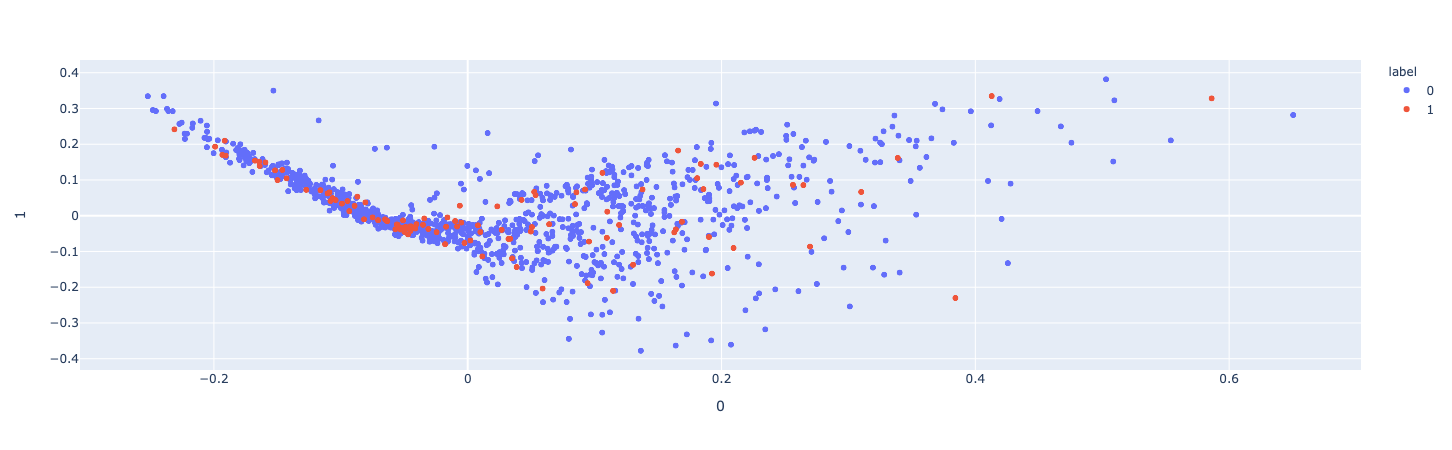

In [148]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import plotly



pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb)

df_emb = pd.DataFrame(emb_pca)
df_emb = pd.concat([df_emb, data], axis=1)

fig = px.scatter(df_emb, x=0, y=1, color="label", hover_data=['description'])
fig.show()
# fig.write_html("figures/file.html")